# BOSS Sky Spectra Calibration

This notebook is looking at the impact of calibration files on sky spectra and the fiber acceptance.

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.table
import glob, fnmatch, os
from scipy import integrate
from astropy.io import fits

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font', size=14, family='serif')

### Conclusions

This notebook explores the flux calibraiton of spFrame flat fielded electrons from BOSS. Here are my conclusions up front.
* There are better calibration files than the one I'm using currently. The best calibration file should give us a fiber acceptance of ~97%.
* I should include R, spFluxcorr and spFluxdistort in the calibration rather than just 1/spCalib
* The impact of the calibration is most clear with observations that have higher seeing. The impacts are not particularly high in the blue/moon area
* Calibration can have rather high implications for the redder wavelengths but not enough to significantly change our observations on the continuum level in the red.

### Find best calibration files

By looking at all the observations on BOSS, each having its own calibration file, we will get the best calibration with an observation with the best seeing closest to zenith.

In [3]:
platelist = astropy.table.Table.read('/global/projecta/projectdirs/sdss/data/sdss/dr12/boss/spectro/redux/platelist.fits')

In [4]:
this_platelist = platelist[platelist['SEEING50']>0]

Text(0.5,0,'Seeing (arcsec)')

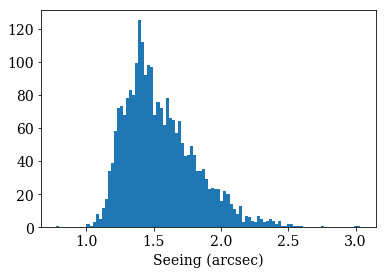

In [23]:
ret = plt.hist(this_platelist['SEEING50'],bins = 100)
plt.xlabel("Seeing (arcsec)")

Text(0.5,0,'Airmass')

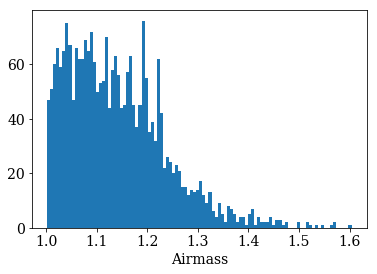

In [25]:
ret = plt.hist(this_platelist['AIRMASS'],bins = 100)
plt.xlabel("Airmass")

Text(0,0.5,'Seeing')

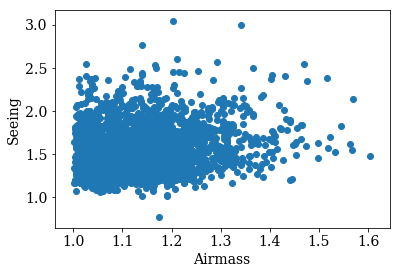

In [26]:
plt.scatter(this_platelist['AIRMASS'], this_platelist['SEEING50'])
plt.xlabel("Airmass")
plt.ylabel("Seeing")

In [8]:
# We want to get the observation in the lower left corner
seeing = [abs(1-see) for see in this_platelist['SEEING50']]
airmass = [abs(1-air) for air in this_platelist['AIRMASS']]

In [9]:
for i, a in enumerate(airmass):
    if a < .01:
        if seeing[i] < .25:
            print(i, a, seeing[i])

117 0.00997996330261 0.243620038033
131 0.00406002998352 0.195799946785
165 0.0091700553894 0.181529998779
189 0.00909996032715 0.190569996834
208 0.00434005260468 0.0672700405121
210 0.00378000736237 0.159330010414
553 0.00375998020172 0.182520031929
1923 0.00493001937866 0.201159954071
2296 0.00207996368408 0.170169949532


In [27]:
best_plate = this_platelist[208]
print("Seeing: %.4f, Airmass: %.4f" %(best_plate['SEEING50'],best_plate['AIRMASS']))

Seeing: 1.0673, Airmass: 1.0043


In [28]:
this_platelist[208]

PLATE,TILEID,MJD,RUN2D,RUN1D,RACEN,DECCEN,EPOCH,CARTID,TAI,TAI_BEG,TAI_END,AIRMASS,EXPTIME,MAPNAME,SURVEY,PROGRAMNAME,CHUNK,PLATEQUALITY,PLATESN2,DEREDSN2,QSURVEY,MJDLIST,NEXP,NEXP_B1,NEXP_B2,NEXP_R1,NEXP_R2,EXPT_B1,EXPT_B2,EXPT_R1,EXPT_R2,SN2_G1,SN2_R1,SN2_I1,SN2_G2,SN2_R2,SN2_I2,DERED_SN2_G1,DERED_SN2_R1,DERED_SN2_I1,DERED_SN2_G2,DERED_SN2_R2,DERED_SN2_I2,GOFFSTD,GRMSSTD,ROFFSTD,RRMSSTD,IOFFSTD,IRMSSTD,GROFFSTD,GRRMSSTD,RIOFFSTD,RIRMSSTD,GOFFGAL,GRMSGAL,ROFFGAL,RRMSGAL,IOFFGAL,IRMSGAL,GROFFGAL,GRRMSGAL,RIOFFGAL,RIRMSGAL,NGUIDE,SEEING20,SEEING50,SEEING80,RMSOFF20,RMSOFF50,RMSOFF80,AIRTEMP,XSIGMA,XSIGMIN,XSIGMAX,WSIGMA,WSIGMIN,WSIGMAX,XCHI2,XCHI2MIN,XCHI2MAX,SKYCHI2,SCHI2MIN,SCHI2MAX,FBADPIX,FBADPIX1,FBADPIX2,N_TOTAL,N_GALAXY,N_QSO,N_STAR,N_UNKNOWN,N_SKY,N_TARGET_MAIN,N_TARGET_LRG1,N_TARGET_LRG2,N_TARGET_QSO,SUCCESS_MAIN,SUCCESS_LRG1,SUCCESS_LRG2,SUCCESS_QSO,STATUS2D,STATUSCOMBINE,STATUS1D,PUBLIC,QUALCOMMENTS
int32,int32,int32,str6,str6,float32,float32,float32,int32,float64,float64,float64,float32,float32,str13,str4,str27,str14,str4,float32,float32,int32,str35,int32,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float32,float32,float32,float32,str4,str6,str7,str4,str83
3985,10256,55320,v5_7_0,v5_7_0,203.838,33.2982,2010.4,11,0.0,4779667070.0,4779670930.84,1.00434,2702.51,3985-55320-01,boss,boss,boss5,good,16.7913,16.7774,1,55320,12,3,3,3,3,2702.51,2702.53,2702.51,2702.53,17.9289,45.3375,41.3675,16.7913,40.9463,31.8515,17.9151,45.3275,41.3599,16.7774,40.9363,31.8439,-0.00273037,0.0555573,-0.0094471,0.0491102,-0.00726891,0.0518264,-0.00255966,0.0355076,-0.0046978,0.0226224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63,1.0,1.06727,1.1634,0.015859,0.0292215,0.0508362,0.0,1.07157,1.02694,1.14171,1.07436,1.04489,1.09681,0.841611,0.685546,0.997547,1.29934,1.21238,1.48142,0.0125208,0.00780591,0.0172357,1000,605,143,82,79,91,0,98,532,251,0.0,96.9388,94.1729,52.5896,Done,Done,Done,DR9,


### How much of the light are we capturing in the fiber? 

In [14]:
old_calib_plate = this_platelist[this_platelist['PLATE'] == 5399]

In [16]:
def gauss(x, fwhm):
    sigma = fwhm/(2*np.sqrt(2*np.log(2)))
    return  (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*(x/sigma)**2.)

g1 = lambda x: gauss(x, best_plate['SEEING50'])
g2 = lambda x: gauss(x, old_calib_plate['SEEING50'])

(0, 1)

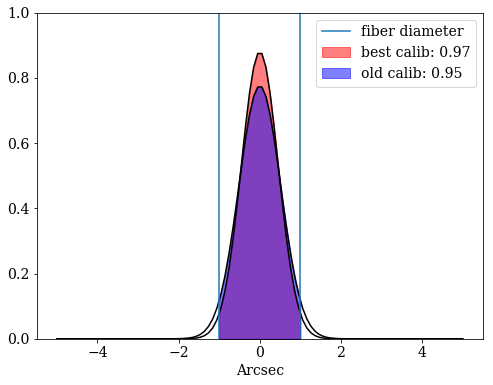

In [22]:
plt.figure(figsize = (8,6))
xx = np.linspace(-5,5,100)
xxx = np.linspace(-1,1,20)
plt.plot(xx, gauss(xx, best_plate['SEEING50']),'k-')
plt.plot(xx, gauss(xx, old_calib_plate['SEEING50']),'k-')

area_frac1 = integrate.quad(g1,-1,1)[0]/integrate.quad(g1,-5,5)[0]
area_frac2 = integrate.quad(g2,-1,1)[0]/integrate.quad(g2,-5,5)[0]
plt.fill_between(xxx,0,gauss(xxx, best_plate['SEEING50']), alpha = 0.5, color = 'red', label = "best calib: %.2f" % area_frac1)
plt.fill_between(xxx,0,gauss(xxx, old_calib_plate['SEEING50']), alpha = 0.5, color = 'blue', label = "old calib: %.2f" % area_frac2)

plt.axvline(-1,label = 'fiber diameter')
plt.axvline(1)
plt.legend(loc = 'upper right')
plt.xlabel("Arcsec")
plt.ylim(0,1)

The best calibration file, with seeing very close to 1 arcsec, if we model the PSF as a gaussian, we capture 97% of the light. The calibration file I was using before collected 95% of the light. There are also other impact to the fiber acceptance, including wavelength and observing hour angle. How much of these are a major concern for us?

### What is impact on Extinction? 

In [30]:
DESI_DIR = '/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/code/desimodel/0.9.4/'

In [31]:
ext_coeff = np.genfromtxt(DESI_DIR+'/data/spectra/ZenithExtinction-KPNO.dat',names=True)

$ T(\lambda) = 10^{-0.4 * \tau_{o}(\lambda) * X}$

In [32]:
zen_ext = 10**(-0.4*ext_coeff['EXTINCTION'])
this_ext = 10**(-0.4*ext_coeff['EXTINCTION']*best_plate['AIRMASS'])
old_ext = 10**(-0.4*ext_coeff['EXTINCTION']*old_calib_plate['AIRMASS'])

Text(0,0.5,'Transmission difference')

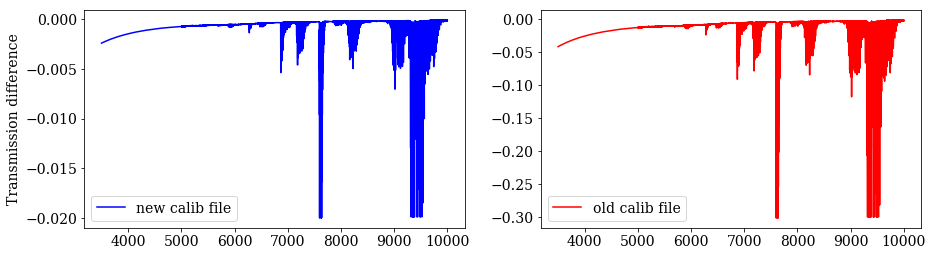

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,4))
ax1.plot(ext_coeff['WAVELENGTH'], (this_ext - zen_ext)/zen_ext, 'b-', label = 'new calib file')
ax2.plot(ext_coeff['WAVELENGTH'], (old_ext - zen_ext)/zen_ext, 'r-', label = 'old calib file')
ax1.legend(loc='lower left')
ax2.legend(loc='lower left')
ax1.set_ylabel("Transmission difference")

The difference in the extinction didn't matter much for the old calibration file (<1% for the continuum), but it is certainly negligible for the new calibration file

## Look at calibration file

In [40]:
calib_folder = '/global/projecta/projectdirs/sdss/data/sdss/dr12/boss/spectro/redux/v5_7_0/3985'
calib_files = glob.glob(calib_folder+'/spFluxcalib-b1-*.fits.gz')

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide


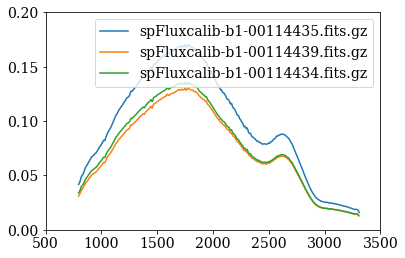

In [41]:
# There were several observations made on that day, for which we have the average seeing and airmass
for i, file in enumerate(calib_files):
    hdu = fits.open(file)
    fn = os.path.split(file)[1]
    plt.plot(1/hdu[0].data[200], label = fn)
    plt.xlim(500,3500)
    plt.ylim(0,.2)
    plt.legend()

In [96]:
info_files = glob.glob(calib_folder+'/spCFrame-b1-*')

for file in info_files:
    hdu = fits.open(file)
    print(file)
    print(hdu[0].header['SEEING50'])
    print(hdu[0].header['AIRMASS'])

/global/projecta/projectdirs/sdss/data/sdss/dr12/boss/spectro/redux/v5_7_0/3985/spCFrame-b1-00114434.fits
1.0881
1.00434
/global/projecta/projectdirs/sdss/data/sdss/dr12/boss/spectro/redux/v5_7_0/3985/spCFrame-b1-00114439.fits
1.0391
1.00396
/global/projecta/projectdirs/sdss/data/sdss/dr12/boss/spectro/redux/v5_7_0/3985/spCFrame-b1-00114435.fits
1.0746
1.00056


In [49]:
#Select observation with best seeing as extinction doesn't matter as much
my_calib_files = glob.glob(calib_folder+'/spFluxcalib-*-00114439*')

### What should be included in the calibration?

In [135]:
obs_data = all_data[(all_data['PLATE'] == 3985)&(all_data['IMG'] == 114439)&(all_data['CAMERAS'] == 'b1')]
fiber = int(np.random.choice(obs_data,1)['FIB'] - 1)

In [136]:
calib_file = glob.glob(calib_folder+'/spFluxcalib-b1-00114439*')
corr_file = glob.glob(calib_folder+'/spFluxcorr-b1-00114439*')
spc_file = glob.glob(calib_folder+'/spCFrame-b1-00114439*')
dist_file = glob.glob(calib_folder+'/spFluxdistort-*.fits')
sp_file = glob.glob(calib_folder+'/spFrame-b1-00114439*')

In [137]:
spc_hdu = fits.open(spc_file[0])
logwave = spc_hdu[3].data[fiber]
binsize = logwave - np.roll(logwave, 1)
binsize[0] = 0

In [138]:
distort = fits.open(dist_file[0])
start = distort[0].header['CRVAL1']  
stepsize = distort[0].header['CD1_1']
xx = np.arange(start, start+(distort[0].data.shape[1]-0.5)*stepsize, stepsize)
distort_fit = np.interp(logwave, xx, distort[0].data[fiber], left=0, right=0)
R = np.ones(len(distort_fit))*10**-4/binsize

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide


In [139]:
corr_hdu = fits.open(corr_file[0])
corr = corr_hdu[0].data[fiber]

calib_hdu = fits.open(calib_file[0])
calib = calib_hdu[0].data[fiber]

spframe = fits.open(sp_file[0])
eflux = spframe[0].data[fiber] + spframe[6].data[fiber]

spcframe = fits.open(spc_file[0])
spc_flux = spcframe[0].data[fiber] + spcframe[6].data[fiber]

In [140]:
wave = (10**logwave)/10
cam_lims = DETECTORS['b1'][0]
limits = np.where((wave > cam_lims[0]) & (wave < cam_lims[1]))

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide


(0, 5)

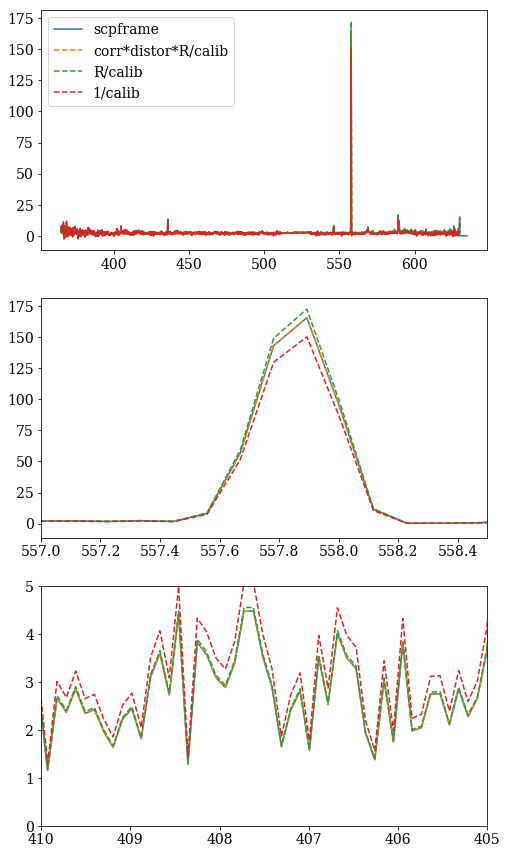

In [143]:
fig, axarr = plt.subplots(3, figsize=(8,15))
first = 1/calib[limits]
second = R[limits]/calib[limits]
third = (distort_fit[limits] * R[limits])/calib[limits]
fourth = (corr[limits]*distort_fit[limits]*R[limits])/calib[limits]
ax = axarr.ravel()

# for i in range(2):
#     ax[i].plot(wave[limits], (spc_flux[limits]-eflux[limits]*first)/eflux[limits]*first, label = 'scpframe')
#     ax[i].plot(wave[limits], (eflux[limits]*fourth-eflux[limits]*first)/eflux[limits]*first, '--',label = 'corr')
#     ax[i].plot(wave[limits], (eflux[limits]*third-eflux[limits]*first)/eflux[limits]*first, '--',label = 'distort')
#     ax[i].plot(wave[limits], (eflux[limits]*second-eflux[limits]*first)/eflux[limits]*first, '--',label = 'R')
#     #ax[i].plot(wave[limits], eflux[limits]*first, '--',label = 'first')
    
for i in range(3):
    ax[i].plot(wave[limits], spc_flux[limits], label = 'scpframe')
    ax[i].plot(wave[limits], eflux[limits]*fourth, '--',label = 'corr*distor*R/calib')
    #ax[i].plot(wave[limits], eflux[limits]*third, '--',label = 'distort')
    ax[i].plot(wave[limits], eflux[limits]*second, '--',label = 'R/calib')
    ax[i].plot(wave[limits], eflux[limits]*first, '--',label = '1/calib')

ax[0].legend()
ax[1].set_xlim(557,558.5)
ax[2].set_xlim(410,405)
ax[2].set_ylim(0,5)

## How does the calibration impact the actual flux measurement?

In [42]:
spectra_dir = '/global/cscratch1/sd/parkerf/sky_flux/'
boss_dir = '/global/projecta/projectdirs/sdss/data/sdss/dr12/boss/spectro/redux/v5_7_0/'

In [43]:
all_data = astropy.table.Table.read('/global/homes/p/parkerf/good_data_2018may11.fits')

In [45]:
#This is the spectrum I've created for spframe flux using a calibration file from 5399
def get_my_spectrum(observation):
    my_spectrum = np.load(spectra_dir+str(observation['PLATE'][0])+'_calibrated_sky.npy')[observation['SPECNO']][0]
    return my_spectrum

In [124]:
DETECTORS = {'b1':[[365,635], 'b1'], 'b2':[[365,635], 'b2'], 'r1':[[565,1040], 'b1'], 'r2':[[565,1040], 'b2']}
def get_new_calibrated_spectrum(observation, calib_files = 'new'): 
    boss_file = glob.glob(boss_dir+'%s/spFrame-%s-00%s.*'%(str(observation['PLATE'][0]), str(observation['CAMERAS'][0]),str(observation['IMG'][0])))
    wave_file = glob.glob(boss_dir+'%s/spCFrame-%s-00%s.*'%(str(observation['PLATE'][0]), str(observation['CAMERAS'][0]),str(observation['IMG'][0])))
    dist_file = glob.glob(calib_folder+'/spFluxdistort-*.fits')
    corr_file = glob.glob(calib_folder+'/spFluxcorr-%s-00114439.*'%str(observation['CAMERAS'][0]))
    calib_spc = glob.glob(calib_folder+'/spCFrame-%s-00114439.*' % str(observation['CAMERAS'][0]))
    fiber_num = observation['FIB'][0] - 1 # for numpy counting
    if fiber_num >= 500:
        fiber_num = fiber_num -500
    
    wave_hdu = fits.open(wave_file[0])
    logwave = wave_hdu[3].data[fiber_num]
    wave = (10**(logwave))/10
    
    calib_spc_hdu = fits.open(calib_spc[0])
    R_logwave = calib_spc_hdu[3].data[fiber_num]
    binsize = R_logwave - np.roll(R_logwave, 1)
    binsize[0] = 0
    R = np.ones(len(R_logwave))*10**-4/binsize
    
    distort = fits.open(dist_file[0])
    start = distort[0].header['CRVAL1']  
    stepsize = distort[0].header['CD1_1']
    xx = np.arange(start, start+(distort[0].data.shape[1]-0.5)*stepsize, stepsize)
    dist = np.interp(logwave, xx, distort[0].data[fiber], left=0, right=0)
    
    corr_hdu = fits.open(corr_file[0])
    corr = corr_hdu[0].data[fiber]
    
    cam_lims = DETECTORS[observation['CAMERAS'][0]][0]
    limits = np.where((wave > cam_lims[0]) & (wave < cam_lims[1]))
    
    boss_data = fits.open(boss_file[0])
    boss_eflux = boss_data[0].data[fiber_num] + boss_data[6].data[fiber_num]
    
    #Get calibration file
    if calib_files == 'new':
        my_calib_file = fnmatch.filter(my_calib_files,'*-%s-*' % str(observation['CAMERAS'][0]))
        calib_hdu = fits.open(my_calib_file[0])
        calib_vector = calib_hdu[0].data[fiber_num]
        new_calib_flux = boss_eflux[limits]/calib_vector[limits]
        
    elif calib_files == 'with_R':
        my_calib_file = fnmatch.filter(my_calib_files,'*-%s-*' % str(observation['CAMERAS'][0]))
        calib_hdu = fits.open(my_calib_file[0])
        calib_vector = calib_hdu[0].data[fiber_num]
        new_calib_flux = boss_eflux[limits]*((corr[limits]*dist[limits]*R[limits])/calib_vector[limits])
        
    elif calib_files == 'spc':
        new_flux = wave_hdu[0].data[fiber_num] + wave_hdu[6].data[fiber_num]
        new_calib_flux = new_flux[limits]
        
    
    return new_calib_flux

Now I'm going to look at how the change in calibration file impacts the sky background in 4 categories: dark sky (in red), bright sky (in blue), Bad seeing (blue and red), and high airmass (blue and red)

### Dark Spectrum

In [51]:
dark_data = all_data[(all_data['CAMERAS'] == 'r1')&(all_data['SEEING50']<1.5)&(all_data['AIRMASS']<1.4)&(all_data['MOON_ALT']<-18)&(all_data['SUN_ALT']<-18)&(all_data['GAL_LAT']>10)]
dark_observation = np.random.choice(dark_data,1)

Seeing: 1.37, Airmass 1.02


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in true_divide


(0, 5)

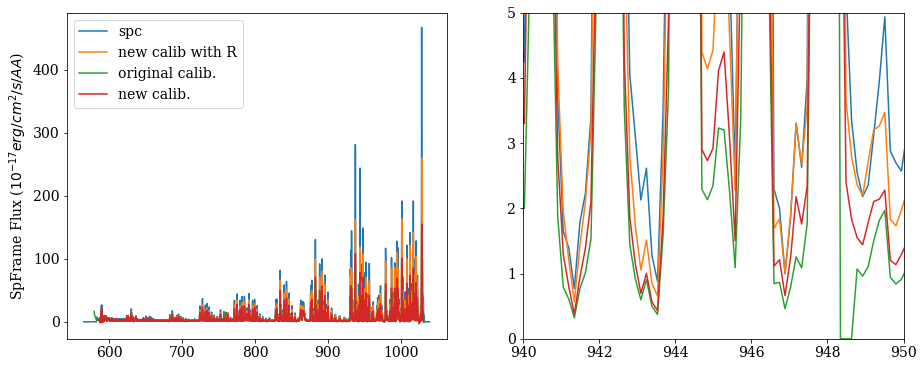

In [125]:
print("Seeing: %.2f, Airmass %.2f" % (dark_observation['SEEING50'], dark_observation['AIRMASS']))

my_dark_spectrum = get_my_spectrum(dark_observation)
new_dark = get_new_calibrated_spectrum(dark_observation)
own_dark = get_new_calibrated_spectrum(dark_observation, calib_files = 'with_R')
spc_dark = get_new_calibrated_spectrum(dark_observation, calib_files = 'spc')

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,6))
ax1.plot(my_dark_spectrum['WAVE'], spc_dark, label = 'spc')
ax1.plot(my_dark_spectrum['WAVE'], own_dark, label = 'new calib with R')
ax1.plot(my_dark_spectrum['WAVE'], my_dark_spectrum['SKY'], label = 'original calib.')
ax1.plot(my_dark_spectrum['WAVE'], new_dark, label = 'new calib.')

ax2.plot(my_dark_spectrum['WAVE'], spc_dark, label = 'spc')
ax2.plot(my_dark_spectrum['WAVE'], own_dark, label = 'new calib with R')
ax2.plot(my_dark_spectrum['WAVE'], my_dark_spectrum['SKY'], label = 'original calib.')
ax2.plot(my_dark_spectrum['WAVE'], new_dark, label = 'new calib.')

ax1.set_ylabel("SpFrame Flux ($10^{-17} erg/cm^{2}/s/AA$)")
ax1.legend()
ax2.set_xlim(940,950)
ax2.set_ylim(0,5)

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in subtract
  app.launch_new_instance()
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


Text(0,0.5,'Calibration difference')

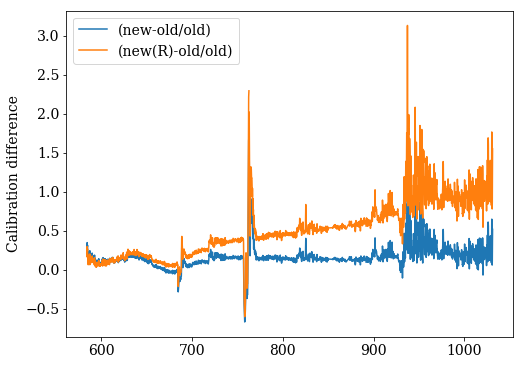

In [126]:
fig, (ax1) = plt.subplots(1, figsize = (8,6))
diff1 = (new_dark - my_dark_spectrum['SKY'])/ my_dark_spectrum['SKY']
diff2 = (own_dark - my_dark_spectrum['SKY'])/ my_dark_spectrum['SKY']
ax1.plot(my_dark_spectrum['WAVE'], diff1, label='(new-old/old)')
ax1.plot(my_dark_spectrum['WAVE'], diff2, label='(new(R)-old/old)')
plt.legend()
ax1.set_ylabel('Calibration difference')

### Bright Spectrum

In [63]:
bright_data = all_data[(all_data['CAMERAS'] == 'b1')&(all_data['SEEING50']<1.5)&(all_data['AIRMASS']<1.4)&(all_data['MOON_ALT']>0)&(all_data['SUN_ALT']<-13)]
bright_observation = np.random.choice(bright_data,1)

Seeing: 1.39, Airmass 1.20


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in true_divide


(7, 20)

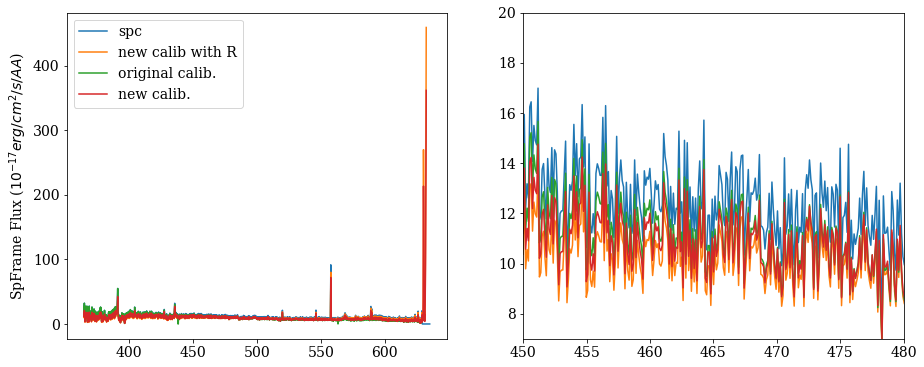

In [129]:
print("Seeing: %.2f, Airmass %.2f" % (bright_observation['SEEING50'], bright_observation['AIRMASS']))

my_bright_spectrum = get_my_spectrum(bright_observation)
new_bright = get_new_calibrated_spectrum(bright_observation)
own_bright = get_new_calibrated_spectrum(bright_observation, calib_files = 'with_R')
spc_bright = get_new_calibrated_spectrum(bright_observation, calib_files = 'spc')

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,6))
ax1.plot(my_bright_spectrum['WAVE'], spc_bright, label = 'spc')
ax1.plot(my_bright_spectrum['WAVE'], own_bright, label = 'new calib with R')
ax1.plot(my_bright_spectrum['WAVE'], my_bright_spectrum['SKY'], label = 'original calib.')
ax1.plot(my_bright_spectrum['WAVE'], new_bright, label = 'new calib.')

ax2.plot(my_bright_spectrum['WAVE'], spc_bright, label = 'spc')
ax2.plot(my_bright_spectrum['WAVE'], own_bright, label = 'new calib with R')
ax2.plot(my_bright_spectrum['WAVE'], my_bright_spectrum['SKY'], label = 'original calib.')
ax2.plot(my_bright_spectrum['WAVE'], new_bright, label = 'new calib.')

ax1.set_ylabel("SpFrame Flux ($10^{-17} erg/cm^{2}/s/AA$)")
ax1.legend()
ax2.set_xlim(450,480)
ax2.set_ylim(7,20)

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in subtract
  app.launch_new_instance()
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarn

Text(0,0.5,'Calibration difference')

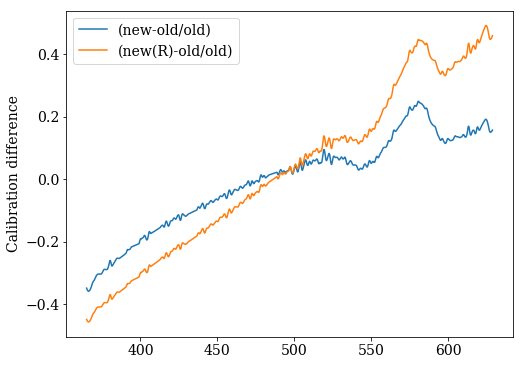

In [130]:
fig, (ax1) = plt.subplots(1, figsize = (8,6))
diff1 = (new_bright - my_bright_spectrum['SKY'])/ my_bright_spectrum['SKY']
diff2 = (own_bright - my_bright_spectrum['SKY'])/ my_bright_spectrum['SKY']
ax1.plot(my_bright_spectrum['WAVE'], diff1, label='(new-old/old)')
ax1.plot(my_bright_spectrum['WAVE'], diff2, label='(new(R)-old/old)')
plt.legend()
ax1.set_ylabel('Calibration difference')

### Bad Seeing Spectrum

In [70]:
bad_seeing = all_data[(all_data['SEEING50']>2.)&(all_data['MOON_ALT']<0)]
bad_seeing_blue_observation = np.random.choice(bad_seeing[bad_seeing['CAMERAS'] == 'b1'],1)
bad_seeing_red_observation = np.random.choice(bad_seeing[bad_seeing['CAMERAS'] == 'r1'],1)

Seeing: 2.11, Airmass 1.23


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in true_divide


(0, 20)

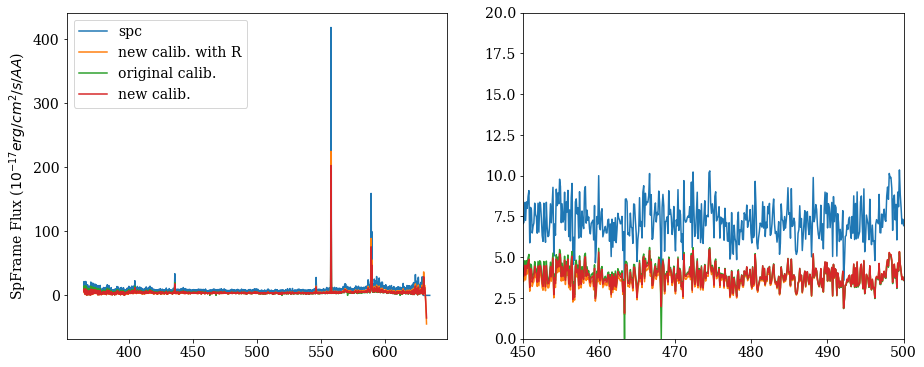

In [131]:
print("Seeing: %.2f, Airmass %.2f" % (bad_seeing_blue_observation['SEEING50'], bad_seeing_blue_observation['AIRMASS']))

my_dark_spectrum = get_my_spectrum(bad_seeing_blue_observation)
new_dark = get_new_calibrated_spectrum(bad_seeing_blue_observation)
own_dark = get_new_calibrated_spectrum(bad_seeing_blue_observation, calib_files = 'with_R')
spc_dark = get_new_calibrated_spectrum(bad_seeing_blue_observation, calib_files = 'spc')

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,6))
ax1.plot(my_dark_spectrum['WAVE'], spc_dark, label = 'spc')
ax1.plot(my_dark_spectrum['WAVE'], own_dark, label = 'new calib. with R')
ax1.plot(my_dark_spectrum['WAVE'], my_dark_spectrum['SKY'], label = 'original calib.')
ax1.plot(my_dark_spectrum['WAVE'], new_dark, label = 'new calib.')

ax2.plot(my_dark_spectrum['WAVE'], spc_dark, label = 'spc')
ax2.plot(my_dark_spectrum['WAVE'], own_dark, label = 'new calib. with R')
ax2.plot(my_dark_spectrum['WAVE'], my_dark_spectrum['SKY'], label = 'original calib.')
ax2.plot(my_dark_spectrum['WAVE'], new_dark, label = 'new calib.')
 
ax1.set_ylabel("SpFrame Flux ($10^{-17} erg/cm^{2}/s/AA$)")
ax1.legend()
ax2.set_xlim(450,500)
ax2.set_ylim(0,20)

Seeing: 2.34, Airmass 1.16


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in true_divide


(0, 20)

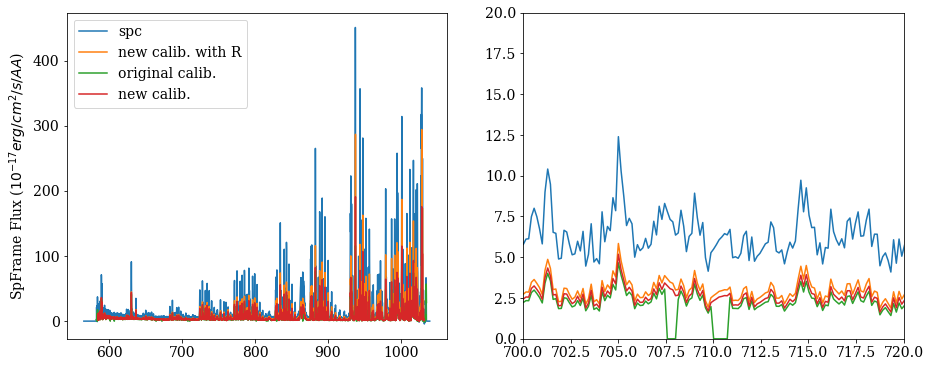

In [132]:
print("Seeing: %.2f, Airmass %.2f" % (bad_seeing_red_observation['SEEING50'], bad_seeing_red_observation['AIRMASS']))

my_dark_spectrum = get_my_spectrum(bad_seeing_red_observation)
new_dark = get_new_calibrated_spectrum(bad_seeing_red_observation)
own_dark = get_new_calibrated_spectrum(bad_seeing_red_observation, calib_files = 'with_R')
spc_dark = get_new_calibrated_spectrum(bad_seeing_red_observation, calib_files = 'spc')

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,6))
ax1.plot(my_dark_spectrum['WAVE'], spc_dark, label = 'spc')
ax1.plot(my_dark_spectrum['WAVE'], own_dark, label = 'new calib. with R')
ax1.plot(my_dark_spectrum['WAVE'], my_dark_spectrum['SKY'], label = 'original calib.')
ax1.plot(my_dark_spectrum['WAVE'], new_dark, label = 'new calib.')

ax2.plot(my_dark_spectrum['WAVE'], spc_dark, label = 'spc')
ax2.plot(my_dark_spectrum['WAVE'], own_dark, label = 'new calib. with R')
ax2.plot(my_dark_spectrum['WAVE'], my_dark_spectrum['SKY'], label = 'original calib.')
ax2.plot(my_dark_spectrum['WAVE'], new_dark, label = 'new calib.')

ax1.set_ylabel("SpFrame Flux ($10^{-17} erg/cm^{2}/s/AA$)")
ax1.legend()
ax2.set_xlim(700,720)
ax2.set_ylim(0,20)

### High Airmass

In [74]:
high_arimass = all_data[(all_data['AIRMASS']>1.4)&(all_data['MOON_ALT']<0)&(all_data['SEEING50']<1.5)&(all_data['SEEING50']>0)]
high_airmass_blue_observation = np.random.choice(high_arimass[high_arimass['CAMERAS'] == 'b1'],1)
high_airmass_red_observation = np.random.choice(high_arimass[high_arimass['CAMERAS'] == 'r1'],1)

Seeing: 1.26, Airmass 1.42


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in true_divide


(0, 10)

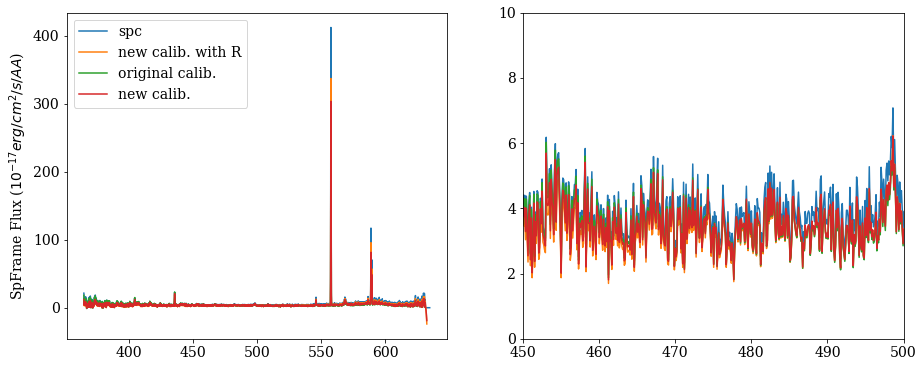

In [133]:
print("Seeing: %.2f, Airmass %.2f" % (high_airmass_blue_observation['SEEING50'], high_airmass_blue_observation['AIRMASS']))

my_dark_spectrum = get_my_spectrum(high_airmass_blue_observation)
new_dark = get_new_calibrated_spectrum(high_airmass_blue_observation)
own_dark = get_new_calibrated_spectrum(high_airmass_blue_observation, calib_files = 'with_R')
spc_dark = get_new_calibrated_spectrum(high_airmass_blue_observation, calib_files = 'spc')

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,6))
ax1.plot(my_dark_spectrum['WAVE'], spc_dark, label = 'spc')
ax1.plot(my_dark_spectrum['WAVE'], own_dark, label = 'new calib. with R')
ax1.plot(my_dark_spectrum['WAVE'], my_dark_spectrum['SKY'], label = 'original calib.')
ax1.plot(my_dark_spectrum['WAVE'], new_dark, label = 'new calib.')

ax2.plot(my_dark_spectrum['WAVE'], spc_dark, label = 'spc')
ax2.plot(my_dark_spectrum['WAVE'], own_dark, label = 'new calib. with R')
ax2.plot(my_dark_spectrum['WAVE'], my_dark_spectrum['SKY'], label = 'original calib.')
ax2.plot(my_dark_spectrum['WAVE'], new_dark, label = 'new calib.')

ax1.set_ylabel("SpFrame Flux ($10^{-17} erg/cm^{2}/s/AA$)")
ax1.legend()
ax2.set_xlim(450,500)
ax2.set_ylim(0,10)

Seeing: 1.48, Airmass 1.51


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in true_divide


(0, 10)

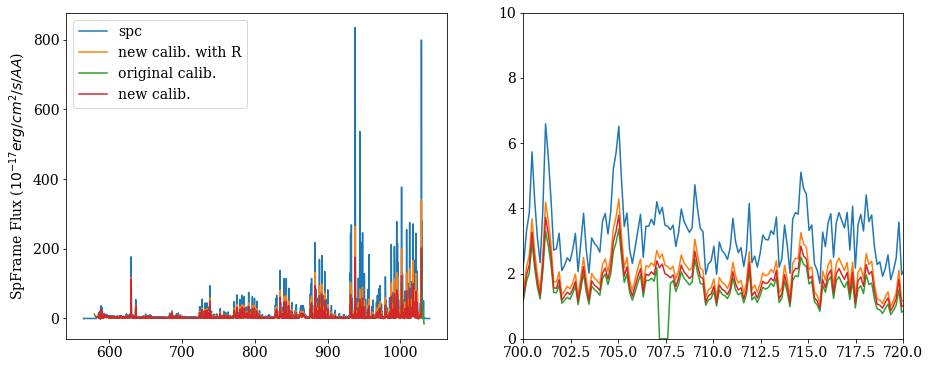

In [134]:
print("Seeing: %.2f, Airmass %.2f" % (high_airmass_red_observation['SEEING50'], high_airmass_red_observation['AIRMASS']))

my_dark_spectrum = get_my_spectrum(high_airmass_red_observation)
new_dark = get_new_calibrated_spectrum(high_airmass_red_observation)
own_dark = get_new_calibrated_spectrum(high_airmass_red_observation, calib_files = 'with_R')
spc_dark = get_new_calibrated_spectrum(high_airmass_red_observation, calib_files = 'spc')

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,6))
ax1.plot(my_dark_spectrum['WAVE'], spc_dark, label = 'spc')
ax1.plot(my_dark_spectrum['WAVE'], own_dark, label = 'new calib. with R')
ax1.plot(my_dark_spectrum['WAVE'], my_dark_spectrum['SKY'], label = 'original calib.')
ax1.plot(my_dark_spectrum['WAVE'], new_dark, label = 'new calib.')

ax2.plot(my_dark_spectrum['WAVE'], spc_dark, label = 'spc')
ax2.plot(my_dark_spectrum['WAVE'], own_dark, label = 'new calib. with R')
ax2.plot(my_dark_spectrum['WAVE'], my_dark_spectrum['SKY'], label = 'original calib.')
ax2.plot(my_dark_spectrum['WAVE'], new_dark, label = 'new calib.')

ax1.set_ylabel("SpFrame Flux ($10^{-17} erg/cm^{2}/s/AA$)")
ax1.legend()
ax2.set_xlim(700,720)
ax2.set_ylim(0,10)

Seeing has the biggest impact on the calibration, but it is obvious that there is a 50% impact across the continuum (more for certain airglow lines) especially at the higher wavelengths. Remaining question is what all needs to be included in my calibration? 